Written by Joao Rodrigues

June 2020

Example: Implements a simple, spatially resolved, 2D harmonic oscillator. Calculates the steady-state, compares with the long-time evolution of the rate equations, and solves the stochastic (steady-state) evolution of the system.

Note: All parameters are defined in SI units

In [13]:
import numpy as np
import scipy.constants as sc
import matplotlib.pyplot as plt
import os
import sys
sys.path.insert(0, os.path.abspath('..'))

## Calculates the cavity modes for a spherical mirror

In [14]:
grid_size = 10.0*1e-6         # meters
grid_delta = 1*1e-6           # meters 
L0 = 2.0*1e-6                 # meters
q = 10                        # longitudinal mode number
n = 1.43
n_modes = 20
feature_RoC = 250.0*1e-6      # meters
feature_depth = 0.279*1e-6    # meters

from PyPBEC.Cavity import Modes
cavity_modes = Modes(grid_size=grid_size, grid_delta=grid_delta, L0=L0, q=q, n=n, n_modes=n_modes)
cavity_modes.set_geometry_spherical(RoC=feature_RoC, depth=feature_depth)
lambdas, modes = cavity_modes.compute_cavity_modes()
g = cavity_modes.get_coupling_matrix()

## Defines the cavity pump profile

In [15]:
pump_width = 1.0*1e-6      # meters
pump_value = 100.0

X, Y = cavity_modes.get_cavity_grid()
pump = np.exp(-(X**2+Y**2) / pump_width**2)
pump = pump_value*(pump/np.sum(pump))
cavity_modes.load_pump(pump=pump)

## Plots the cavity modes and the pump profile

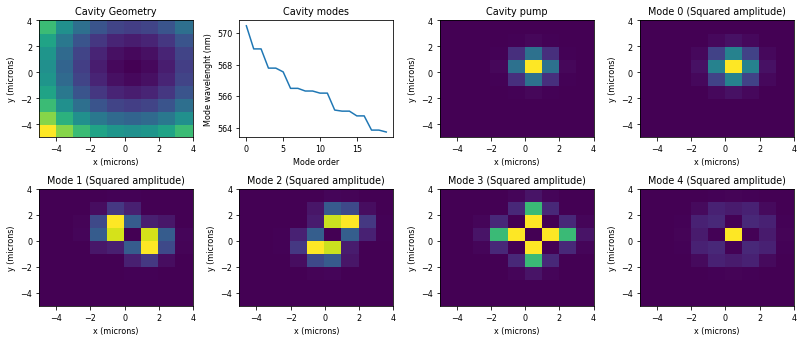

In [16]:
cavity_modes.plot_cavity()

## Calculates emission and absorption rates from experimental data

In [17]:
dye_concentration = 2.0       # in mM, with 1 mM=1mol/m^3

from PyPBEC.OpticalMedium import OpticalMedium
R6G = OpticalMedium(optical_medium="Rhodamine6G")
absorption_rates, emission_rates = R6G.get_rates(lambdas=lambdas, dye_concentration=dye_concentration, n=n)

#### Normalizes the rates, for better numerical performance

In [18]:
cavity_loss_rate = 1.0/(10*1e-12)    # in s^^-1

cavity_loss_rates = np.ones(n_modes)
emission_rates = emission_rates / cavity_loss_rate
absorption_rates = absorption_rates / cavity_loss_rate

## Defines a cavity

In [19]:
# Properties of the photonic modes
from PyPBEC.Cavity import Cavity
cavity = Cavity(M=n_modes, J=g.shape[1])
cavity.set_cavity_loss_rates(rates=cavity_loss_rates)
cavity.set_cavity_emission_rates(rates=emission_rates)
cavity.set_cavity_absorption_rates(rates=absorption_rates)

# Properties of the molecular modes
cavity.set_reservoir_decay_rates(rates=np.ones(g.shape[1]))
cavity.set_reservoir_pump_rates(rates=np.reshape(pump, [pump.shape[0]*pump.shape[1]]))
molecular_population = np.array(sc.Avogadro*dye_concentration*(0.5*L0*grid_delta**2)*np.ones(g.shape[1]), dtype=int)
cavity.set_reservoir_population(population=molecular_population)

# Coupling between photonic and molecular modes
cavity.set_coupling_terms(coupling_terms=g)

## Solves the mean-field steady-state

In [20]:
from PyPBEC.Solver import SteadyState
solver_steadystate = SteadyState(cavity_obj=cavity)
solver_steadystate.set_initial_photons(initial_photons=np.array(np.zeros(n_modes), dtype=int))
solver_steadystate.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(g.shape[1]),dtype=int))
solved_cavity_steadystate = solver_steadystate.solve()
# Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
mode_degeneracy = np.array([j for j in range(0, n_modes) for i in range(0, j)][0:n_modes])
steady_state_photon_population = [np.sum(solved_cavity_steadystate.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
    for mode_number in list(set(list(mode_degeneracy)))]
steady_state_photon_population = np.transpose(np.array(steady_state_photon_population, dtype=float))

## Solves the mean-field rate equations

In [21]:
n_points = 1000
ode_int_time = 15.0

from PyPBEC.Solver import ODE
solver_ode = ODE(cavity_obj=cavity, T=ode_int_time, n_points=n_points)
solver_ode.set_initial_photons(initial_photons=np.array(np.zeros(n_modes), dtype=int))
solver_ode.set_initial_excited_molecules(initial_excited_molecules=np.array(np.zeros(g.shape[1]),dtype=int))
solved_cavity_ode = solver_ode.solve()
# Sums the populations over the mode degeneracy, g=n+1, with n=0,1,2,...
mode_degeneracy = np.array([j for j in range(0, n_modes+1) for i in range(0, j)][0:n_modes])
time = solved_cavity_ode.t
photon_population = [np.sum(solved_cavity_ode.photons[:,np.where(mode_degeneracy==mode_number)[0]], 1) 
                     for mode_number in list(set(list(mode_degeneracy)))]
photon_population = np.transpose(np.array(photon_population, dtype=float))

## Plots the mean-field solution and compares with the steady-state

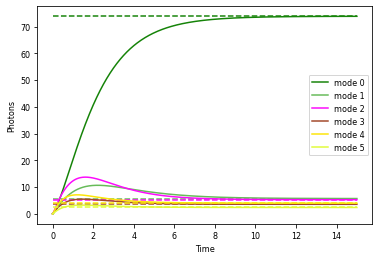

In [22]:
colors = [[np.random.uniform(), np.random.uniform(), np.random.uniform()] for i in range(0, photon_population.shape[1])]
[[plt.plot(time, photon_population[:,i], '-', color=colors[i], label="mode {0}".format(i)),
	plt.plot([time[0], time[-1]], [steady_state_photon_population[0,i], steady_state_photon_population[0,i]], '--', color=colors[i])]
	for i in range(0, photon_population.shape[1])]
plt.legend()
plt.xlabel("Time")
plt.ylabel("Photons")
plt.show()


## Keeps solving the cavity dynamics with a Monte Carlo solver

In [23]:
mc_int_time = 200.0
n_points_mc = 1000

from PyPBEC.Solver import MonteCarlo
solver_mc = MonteCarlo(cavity_obj=cavity, T=mc_int_time, n_points=n_points_mc)
solver_mc.set_initial_photons(initial_photons=np.array(solved_cavity_ode.photons[-1], dtype=int))
solver_mc.set_initial_excited_molecules(initial_excited_molecules=np.array(solved_cavity_ode.emols[-1], dtype=int))
solved_cavity_mc = solver_mc.solve()


## Plots the stochastic cavity dynamics

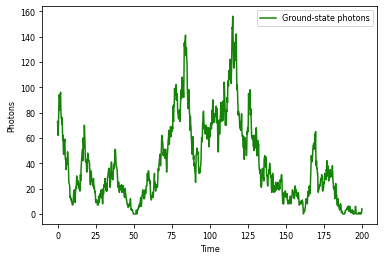

In [24]:
time = solved_cavity_mc.t
photon_population = solved_cavity_mc.photons
plt.plot(time, photon_population[:,0], color=colors[0], label="Ground-state photons")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Photons")
plt.show()
